In [34]:
# Basic imports
import numpy as np
import pandas as pd
import time

from transformers import AutoTokenizer, AutoModel
import torch

# Your existing drug data (if you want to load it)
import pickle
from sklearn.cluster import KMeans

import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler

In [8]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Use CPU for now (easier setup)
device = "cpu"
model.to(device)

print(f"Model loaded: {model_name}")
print(f"Model size: {model.num_parameters():,} parameters")

tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: DeepChem/ChemBERTa-77M-MTR
Model size: 3,427,440 parameters


model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

In [9]:
test_drugs = {
    "olaparib": "C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC(=O)C5=CC=CC=C54)F",
    "Zileuton": "CC(C1=CC2=CC=CC=C2S1)N(C(=O)N)O", 
    "Paclitaxel": "CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C"
}

In [10]:
for drug_name, smiles in test_drugs.items():
    print(f"\n=== {drug_name.upper()} ===")
    print(f"SMILES: {smiles}")
    
    # YOUR CODE: Tokenize the SMILES
    tokens = tokenizer.tokenize(smiles)  # Use tokenizer.tokenize()
    token_ids = tokenizer.encode(smiles)  # Use tokenizer.encode()
    
    print(f"Number of tokens: {len(tokens)}")
    print(f"Tokens: {tokens[:10]}...")  # Show first 10 tokens


=== OLAPARIB ===
SMILES: C1CC1C(=O)N2CCN(CC2)C(=O)C3=C(C=CC(=C3)CC4=NNC(=O)C5=CC=CC=C54)F
Number of tokens: 64
Tokens: ['C', '1', 'C', 'C', '1', 'C', '(', '=', 'O', ')']...

=== ZILEUTON ===
SMILES: CC(C1=CC2=CC=CC=C2S1)N(C(=O)N)O
Number of tokens: 31
Tokens: ['C', 'C', '(', 'C', '1', '=', 'C', 'C', '2', '=']...

=== PACLITAXEL ===
SMILES: CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)C(C(C5=CC=CC=C5)NC(=O)C6=CC=CC=C6)O)O)OC(=O)C7=CC=CC=C7)(CO4)OC(=O)C)O)C)OC(=O)C
Number of tokens: 126
Tokens: ['C', 'C', '1', '=', 'C', '2', 'C', '(', 'C', '(']...


In [20]:
def get_embedding(smiles_string):
    inputs = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        hidden = outputs.last_hidden_state  # [1, seq_len, 768]
        mask = inputs['attention_mask'].unsqueeze(-1).expand(hidden.size()).float()
        summed = torch.sum(hidden * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)
        mean_pooled = summed / counts
    
    return mean_pooled.squeeze().numpy()

In [21]:
with open('drug_smiles.pkl', 'rb') as f:
    drug_to_pubchem = pickle.load(f)

In [42]:
filtered_drug_to_pubchem = {
    drug: info
    for drug, info in drug_to_pubchem.items()
    if isinstance(info, dict)
    and "smiles" in info
    and isinstance(info["smiles"], str)
    and info["smiles"].lower() != "not found"
    and not info["smiles"].lower().startswith("error")
}

In [43]:
embedding_results = {}

for drug, result in filtered_drug_to_pubchem.items():
    smiles = result['smiles'] 
    print(f"\n=== Testing {drug} ===")
    
    # Use the function with the SMILES string
    embedding = get_embedding(smiles)
    
    # Store and print results
    embedding_results[drug] = embedding
    print(f"Embedding shape: {embedding.shape}")
    print(f"First 5 values: {embedding[:5]}")


=== Testing olaparib ===
Embedding shape: (384,)
First 5 values: [-0.24636887  0.4498816  -0.15651259  0.08085908  0.4804444 ]

=== Testing Zileuton ===
Embedding shape: (384,)
First 5 values: [-0.01107316  0.3084911  -0.0566361   0.08092873 -0.08604751]

=== Testing Paclitaxel ===
Embedding shape: (384,)
First 5 values: [ 0.07084595  0.5695135  -0.12836751  0.97298604  0.5899318 ]

=== Testing Acetazolamide ===
Embedding shape: (384,)
First 5 values: [-0.14751936  0.4582512  -0.13709146  0.1444535  -0.26624593]

=== Testing Cytarabine ===
Embedding shape: (384,)
First 5 values: [-0.06326431  0.09677581 -0.0507481   0.34345528  0.03954466]

=== Testing ULK-101 ===
Embedding shape: (384,)
First 5 values: [ 0.00576801  0.23231928 -0.15010878  0.03408558  0.3941495 ]

=== Testing Entrectinib ===
Embedding shape: (384,)
First 5 values: [-0.05110233  0.45858684 -0.10433289  0.17008275  0.60208625]

=== Testing APTO-253 ===
Embedding shape: (384,)
First 5 values: [-0.30809924  0.5783203  -0

/Users/tyler/miniconda3/envs/scbasecount-py/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


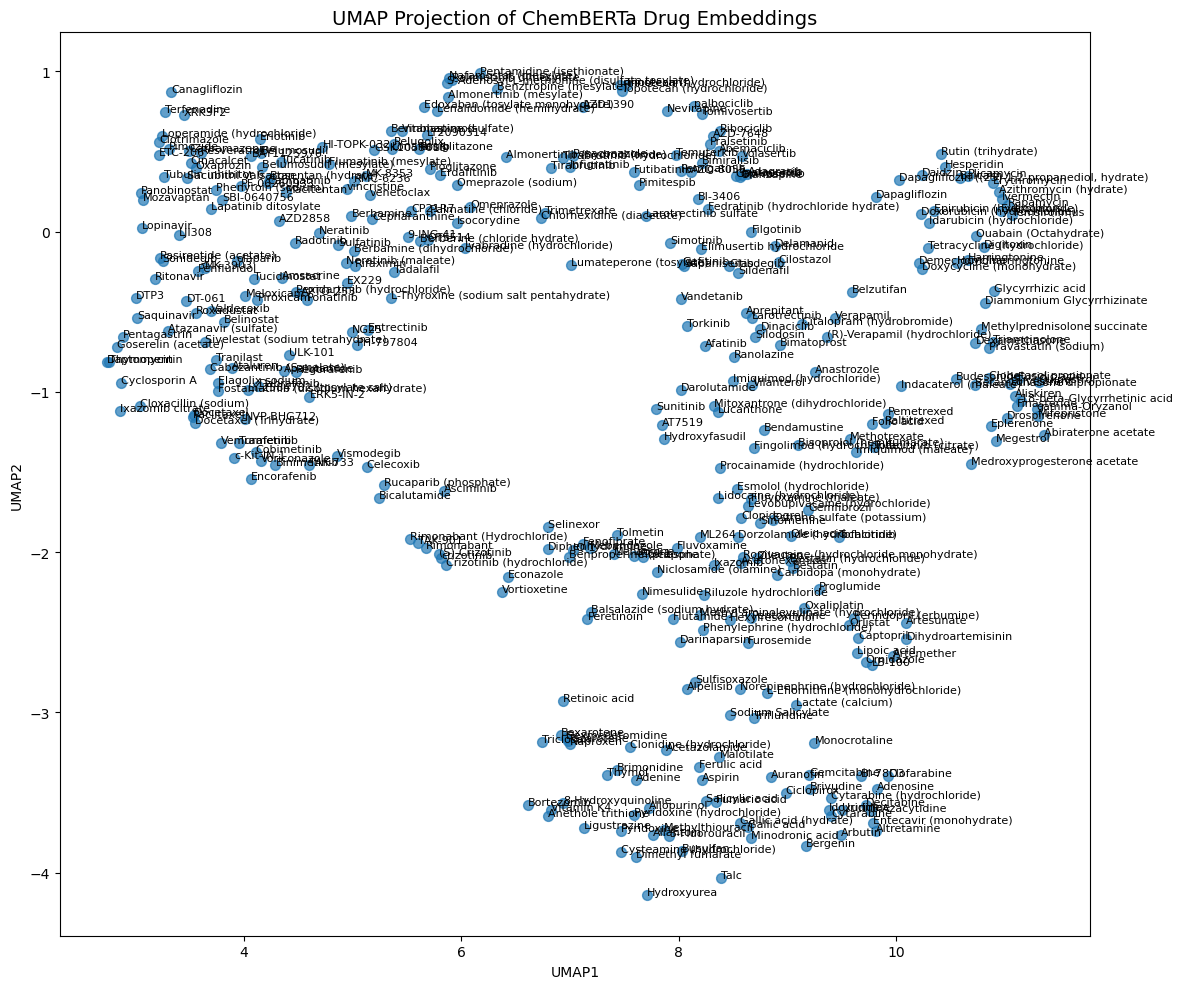

In [44]:
drug_names = list(embedding_results.keys())
X = np.vstack([embedding_results[name].squeeze() for name in drug_names])

# Step 2: Standardize
X_scaled = StandardScaler().fit_transform(X)

# Step 3: Fit UMAP
umap = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X_umap = umap.fit_transform(X_scaled)

# Step 4: Plot
plt.figure(figsize=(12, 10))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=50, alpha=0.7)

# Add labels
for i, name in enumerate(drug_names):
    plt.text(X_umap[i, 0], X_umap[i, 1], name, fontsize=8)

plt.title("UMAP Projection of ChemBERTa Drug Embeddings", fontsize=14)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()

In [45]:
drug_names = list(embedding_results.keys())
X = np.vstack([embedding_results[name].squeeze() for name in drug_names])

# Step 2: Normalize
X_scaled = StandardScaler().fit_transform(X)

# Step 3: UMAP for visualization
umap = UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
X_umap = umap.fit_transform(X_scaled)

# Step 4: KMeans clustering
n_clusters = 4  # ← Change this as desired
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)
cluster_labels = kmeans.labels_

# Step 5: Create summary DataFrame
df = pd.DataFrame({
    "Drug": drug_names,
    "SMILES": [drug_to_pubchem[name] for name in drug_names],
    "Cluster": cluster_labels,
    "UMAP1": X_umap[:, 0],
    "UMAP2": X_umap[:, 1]
})


/Users/tyler/miniconda3/envs/scbasecount-py/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [38]:
df.to_csv("chemberta_cluster_output.csv", index=False)

In [48]:
check = df[(df['UMAP1'] > 10) & (df['UMAP2'] > 0)]

In [49]:
check

,Drug,SMILES,Cluster,UMAP1,UMAP2
13,Ivermectin,{'smiles': 'CCC(C)C1C(CCC2(O1)CC3CC(O2)CC=C(C(...,2,10.973341,0.207160
25,Erythromycin,{'smiles': 'CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O...,2,10.894814,0.302423
73,Daidzin,{'smiles': 'C1=CC(=CC=C1C2=COC3=C(C2=O)C=CC(=C...,0,10.241463,0.351755
106,Rutin (trihydrate),{'smiles': 'CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C...,1,10.414606,0.487884
107,"Dapagliflozin ((2S)-1,2-propanediol, hydrate)",{'smiles': 'CCOC1=CC=C(C=C1)CC2=C(C=CC(=C2)C3C...,0,10.023603,0.320433
146,Temsirolimus,{'smiles': 'CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(...,2,11.067550,0.106554
150,Rapamycin,{'smiles': 'CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(...,2,11.028330,0.168592
194,Epirubicin (hydrochloride),{'smiles': 'CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C...,2,10.351228,0.129349
218,Hesperidin,{'smiles': 'CC1C(C(C(C(O1)OCC2C(C(C(C(O2)OC3=C...,0,10.452931,0.405621
255,Everolimus,{'smiles': 'CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(...,2,10.963093,0.128383
